<a href="https://colab.research.google.com/github/Raghavisgeek/dental_lesion_xray_segmentation_yolo/blob/main/dental_lesionsegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import cv2
import shutil
import random
import numpy as np
from tqdm import tqdm
from glob import glob

# ================== USER CONFIGURATION ==================
# 1. Where are the MASKS? (The black images with white blobs)
MASK_DIR = "/content/drive/MyDrive/Colab_Notebooks/PAL DATASET/PAI dataset final target/Shaded Annotated Lesion"

# 2. Where are the LESION IMAGES? (The raw X-rays of sick teeth)
#    (We will search inside this folder recursively)
LESION_IMG_ROOT = "/content/drive/MyDrive/Colab_Notebooks/PAL DATASET/PAI dataset final target/Cropped and Resized/LP (Non annotated)/LP(Non-Annotated)"

# 3. Where are the HEALTHY IMAGES? (The raw X-rays of good teeth)
#    (Point this to your 'Cropped Molar Teeth' folder)
HEALTHY_IMG_DIR = "/content/drive/MyDrive/Colab_Notebooks/PAL DATASET/PAI dataset final target/Cropped and Resized/MT (Molar Teeth)"

# 4. Output Directory (Where we build the dataset)
OUTPUT_BASE = "/content/yolo_dental_dataset"
# ========================================================

def create_dirs():
    if os.path.exists(OUTPUT_BASE): shutil.rmtree(OUTPUT_BASE)
    for split in ['train', 'val']:
        os.makedirs(f"{OUTPUT_BASE}/{split}/images", exist_ok=True)
        os.makedirs(f"{OUTPUT_BASE}/{split}/labels", exist_ok=True)

def normalize_polygon(contour, width, height):
    """Converts pixel coordinates to 0-1 normalized YOLO format"""
    polygon = []
    for point in contour:
        x, y = point[0]
        polygon.append(max(0, min(x/width, 1.0)))
        polygon.append(max(0, min(y/height, 1.0)))
    return polygon

def find_image_recursive(root_dir, filename_no_ext):
    """Searches for an image file in all subfolders"""
    # Look for .jpg, .png, .jpeg
    for ext in ['.jpg', '.png', '.jpeg', '.bmp']:
        # We use glob to search recursively (**)
        search_pattern = os.path.join(root_dir, "**", f"{filename_no_ext}{ext}")
        matches = glob(search_pattern, recursive=True)
        if matches:
            return matches[0] # Return first match
    return None

def process_dataset():
    print("🚀 Starting Dental Dataset Generation...")
    create_dirs()

    # --- PART 1: PROCESS LESIONS (SICK TEETH) ---
    print(f"Phase 1: Matching Masks from {os.path.basename(MASK_DIR)}...")
    mask_files = [f for f in os.listdir(MASK_DIR) if f.lower().endswith(('.png', '.jpg'))]

    matched_count = 0
    for mask_file in tqdm(mask_files):
        # 1. Read Mask
        mask_path = os.path.join(MASK_DIR, mask_file)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None: continue

        # Threshold to ensure binary
        _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        h, w = mask.shape

        # 2. Find Matching Image
        basename = os.path.splitext(mask_file)[0]
        # Helper: Remove "Copy of" if it exists, sometimes Drive adds this
        clean_basename = basename.replace("Copy of ", "").strip()

        img_path = find_image_recursive(LESION_IMG_ROOT, clean_basename)

        if not img_path:
            # Try searching just by the number if names are like "Image (1).jpg"
            # This is a "Hail Mary" search if exact names fail
            continue

        # 3. Convert Mask to Polygons
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        yolo_lines = []
        for cnt in contours:
            if cv2.contourArea(cnt) > 50: # Ignore tiny noise
                poly = normalize_polygon(cnt, w, h)
                if len(poly) >= 6:
                    yolo_lines.append(f"0 {' '.join([f'{p:.6f}' for p in poly])}")

        if not yolo_lines: continue # Skip if mask is empty

        # 4. Save
        split = 'train' if random.random() < 0.8 else 'val'
        shutil.copy(img_path, f"{OUTPUT_BASE}/{split}/images/{clean_basename}.jpg")
        with open(f"{OUTPUT_BASE}/{split}/labels/{clean_basename}.txt", 'w') as f:
            f.write("\n".join(yolo_lines))
        matched_count += 1

    print(f"✅ Phase 1 Done. Matched {matched_count} Lesion Images.")

    # --- PART 2: PROCESS HEALTHY (MOLAR TEETH) ---
    print(f"Phase 2: Processing Healthy Images from {os.path.basename(HEALTHY_IMG_DIR)}...")

    if os.path.exists(HEALTHY_IMG_DIR):
        healthy_files = [f for f in os.listdir(HEALTHY_IMG_DIR) if f.lower().endswith(('.jpg', '.png'))]

        for h_file in tqdm(healthy_files):
            src_path = os.path.join(HEALTHY_IMG_DIR, h_file)
            split = 'train' if random.random() < 0.8 else 'val'

            # Copy Image
            shutil.copy(src_path, f"{OUTPUT_BASE}/{split}/images/{h_file}")

            # Create EMPTY Label File (Crucial for "Healthy" class)
            txt_name = os.path.splitext(h_file)[0] + ".txt"
            with open(f"{OUTPUT_BASE}/{split}/labels/{txt_name}", 'w') as f:
                pass # Create empty file

        print(f"✅ Phase 2 Done. Added {len(healthy_files)} Healthy Images.")
    else:
        print("⚠️ WARNING: Healthy Image Folder not found. Check path!")

    print(f"\n🎉 Dataset Ready at: {OUTPUT_BASE}")

process_dataset()

🚀 Starting Dental Dataset Generation...
Phase 1: Matching Masks from Shaded Annotated Lesion...


100%|██████████| 122/122 [00:06<00:00, 19.11it/s]


✅ Phase 1 Done. Matched 122 Lesion Images.
Phase 2: Processing Healthy Images from MT (Molar Teeth)...


100%|██████████| 85/85 [00:01<00:00, 53.61it/s] 

✅ Phase 2 Done. Added 85 Healthy Images.

🎉 Dataset Ready at: /content/yolo_dental_dataset


In [4]:
# 1. Create Config
yaml_content = """
path: /content/yolo_dental_dataset
train: train/images
val: val/images

names:
  0: lesion
"""

with open('/content/dental_config.yaml', 'w') as f:
    f.write(yaml_content)

# 2. Install YOLO (if not already installed)
!pip install ultralytics

# 3. Train
from ultralytics import YOLO

# We use the Segmentation model
model = YOLO('yolov8n-seg.pt')

print("Starting Training...")
results = model.train(
    data='/content/dental_config.yaml',
    epochs=100,
    imgsz=224,       # Matches your "Resized" images
    batch=16,
    patience=20,
    augment=True,
    project='Dental_Project',
    name='Final_Run'
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.2 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Starting Training...
Ultralytics 8.3.230 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dental_config.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, fr


image 1/1 /content/yolo_dental_dataset/val/images/LP2.jpg: 224x192 2 lesions, 51.3ms
Speed: 0.6ms preprocess, 51.3ms inference, 11.2ms postprocess per image at shape (1, 3, 224, 192)


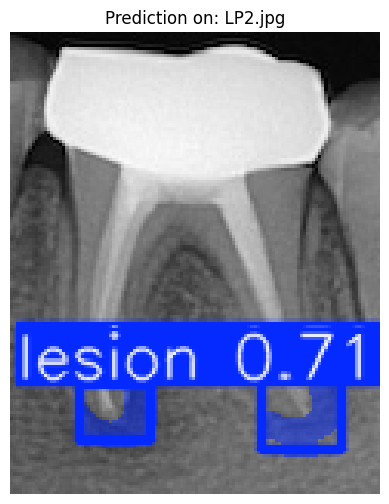

⚠️ LESION DETECTED!
🩸 Lesion Area (Pixels): 764.00
👉 Estimated PAI Score: 4 (Periodontitis)


In [5]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import glob
import random
import os

# 1. Load your BEST model (saved automatically)
model = YOLO('/content/Dental_Project/Final_Run/weights/best.pt')

# 2. Pick a random image from the Validation set
val_images = glob.glob("/content/yolo_dental_dataset/val/images/*.jpg")
test_img_path = random.choice(val_images)

# 3. Run Inference
results = model(test_img_path)
result = results[0]

# 4. visualize
plt.figure(figsize=(12, 6))

# Original Image with Overlay
img_plot = result.plot() # Draws the mask on the image
plt.imshow(cv2.cvtColor(img_plot, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Prediction on: {os.path.basename(test_img_path)}")
plt.show()

# 5. THE MAGIC: Calculate Lesion Size for PAI
if result.masks is not None:
    # Get the mask area (number of pixels)
    mask_data = result.masks.data[0].cpu().numpy()
    pixel_area = mask_data.sum()

    print(f"⚠️ LESION DETECTED!")
    print(f"🩸 Lesion Area (Pixels): {pixel_area:.2f}")

    # Simple Logic for PAI (You can tune these numbers later)
    if pixel_area < 500:
        print("👉 Estimated PAI Score: 3 (Small Change)")
    elif pixel_area < 1500:
        print("👉 Estimated PAI Score: 4 (Periodontitis)")
    else:
        print("👉 Estimated PAI Score: 5 (Severe)")
else:
    print("✅ No Lesion Detected (Healthy / PAI 1-2)")

In [7]:
from ultralytics import YOLO

# LOAD THE MEDIUM MODEL (The "Big Brain")
# This is much smarter than the Nano model you used before.
model = YOLO('yolov8m-seg.pt')

print("🚀 Starting High-Accuracy Training...")

results = model.train(
    data='/content/dental_config.yaml',
    epochs=150,           # Train longer
    imgsz=512,            # High Definition (Crucial for Medical accuracy)
    batch=8,              # Lower batch size to fit big model in memory
    patience=25,          # Wait longer before stopping
    augment=True,         # Force it to learn harder examples
    cos_lr=True,          # 'Cosine Annealing' - Helps squeeze out last % of accuracy
    project='Dental_Project',
    name='Pro_Model_Medium'
)

🚀 Starting High-Accuracy Training...
Ultralytics 8.3.230 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/dental_config.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=Pro_Model_Medium, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, 

🚀 Sending image to https://unpromoted-issuably-dannie.ngrok-free.dev...
INFO:     34.148.69.170:0 - "POST /predict HTTP/1.1" 200 OK


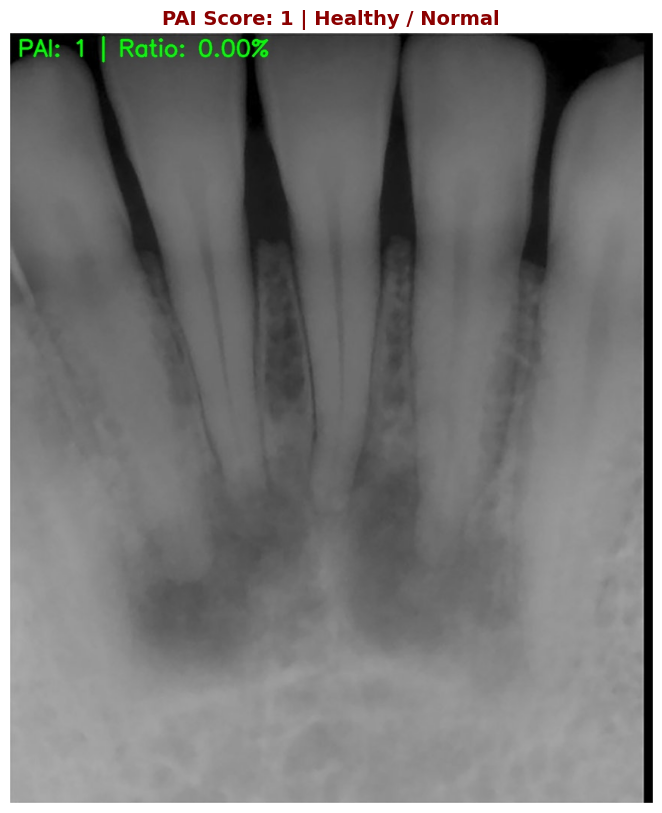

📊 DETAILED REPORT:
-------------------
Structure Area: 821022 px
Lesion Area:    0 px
Risk Ratio:     0.0%


In [26]:
import requests
import cv2
import numpy as np
import base64
import matplotlib.pyplot as plt

# ==========================================
# 1. YOUR NEW URL
# ==========================================
API_URL = "https://unpromoted-issuably-dannie.ngrok-free.dev"
IMAGE_PATH = "/content/test.jpg"  # <--- Upload an image here first!
# ==========================================

print(f"🚀 Sending image to {API_URL}...")

try:
    with open(IMAGE_PATH, "rb") as f:
        response = requests.post(f"{API_URL}/predict", files={"file": f})

    if response.status_code == 200:
        result = response.json()

        # Decode the annotated image sent back by the server
        img_data = base64.b64decode(result['annotated_image_base64'])
        nparr = np.frombuffer(img_data, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Display
        plt.figure(figsize=(10, 10))
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(f"PAI Score: {result['pai_score']} | {result['description']}",
                  color='darkred', fontweight='bold', fontsize=14)
        plt.show()

        print(f"📊 DETAILED REPORT:")
        print(f"-------------------")
        print(f"Structure Area: {result['structure_area_px']} px")
        print(f"Lesion Area:    {result['lesion_area_px']} px")
        print(f"Risk Ratio:     {result['lesion_ratio_percent']}%")
    else:
        print("❌ Error:", response.text)

except FileNotFoundError:
    print("⚠️ STOP: You need to upload an image named 'test.jpg' to the Colab file folder on the left!")

In [23]:
# ===========================
# 1. INSTALL DEPENDENCIES
# ===========================
!pip install fastapi python-multipart uvicorn pyngrok opencv-python-headless ultralytics

import cv2
import numpy as np
import io
import base64
from fastapi import FastAPI, File, UploadFile
from fastapi.responses import JSONResponse
import uvicorn
from pyngrok import ngrok
import nest_asyncio
from ultralytics import YOLO
import threading

# Apply nest_asyncio to allow running uvicorn in a notebook
nest_asyncio.apply()

# ===========================
# 2. LOAD MODEL & DEFINE LOGIC
# ===========================
# Load your best trained model
model = YOLO('/content/Dental_Project/Pro_Model_Medium/weights/best.pt')

# Smart PAI Thresholds (Lesion Area / Bright Structure Area %)
RATIO_PAI_2 = 0.5
RATIO_PAI_3 = 3.0
RATIO_PAI_4 = 8.0

def get_pai_score_smart(ratio):
    if ratio == 0: return 1, "Healthy / Normal"
    if ratio < RATIO_PAI_2: return 2, "Small Changes (PAI 2)"
    if ratio < RATIO_PAI_3: return 3, "Mineral Loss (PAI 3)"
    if ratio < RATIO_PAI_4: return 4, "Periodontitis (PAI 4)"
    return 5, "Severe Periodontitis (PAI 5)"

# ===========================
# 3. CREATE API APPLICATION
# ===========================
app = FastAPI()

@app.get("/")
def home():
    return {"message": "Dental PAI Scoring API is Running!"}

@app.post("/predict")
async def predict(file: UploadFile = File(...)):
    # 1. Read Uploaded Image
    contents = await file.read()
    nparr = np.frombuffer(contents, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

    # 2. Run Smart PAI Logic
    # A. Find Structure (Bright Pixels)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, structure_mask = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)
    total_structure_area = np.sum(structure_mask > 0)

    # B. Run Model Inference
    results = model(img, conf=0.25, verbose=False)
    result = results[0]

    total_lesion_area = 0
    mask_combined = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

    if result.masks is not None:
        for mask_data in result.masks.data:
            m = mask_data.cpu().numpy()
            m = cv2.resize(m, (img.shape[1], img.shape[0]))
            mask_combined = np.maximum(mask_combined, m)
        total_lesion_area = np.sum(mask_combined > 0.5)

    # C. Calculate Ratio & Score
    smart_ratio = 0
    if total_structure_area > 0:
        smart_ratio = (total_lesion_area / total_structure_area) * 100

    pai_score, description = get_pai_score_smart(smart_ratio)

    # 3. Create Visual Result Image
    overlay = img.copy()
    # Draw Red Lesion
    overlay[mask_combined > 0.5] = [0, 0, 255] # BGR for OpenCV
    # Blend
    final_img = cv2.addWeighted(overlay, 0.5, img, 0.5, 0)

    # Add Text to Image
    text = f"PAI: {pai_score} | Ratio: {smart_ratio:.2f}%"
    cv2.putText(final_img, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 255, 0), 2, cv2.LINE_AA)

    # 4. Encode Image to Send Back
    _, encoded_img = cv2.imencode('.jpg', final_img)
    img_base64 = base64.b64encode(encoded_img).decode('utf-8')

    # 5. Return JSON Response
    return {
        "pai_score": pai_score,
        "description": description,
        "lesion_ratio_percent": round(smart_ratio, 2),
        "lesion_area_px": int(total_lesion_area),
        "structure_area_px": int(total_structure_area),
        "annotated_image_base64": img_base64
    }

# ===========================
# 4. START SERVER WITH NGROK
# ===========================
# --- PASTE YOUR NGROK AUTHTOKEN HERE ---
ngrok.set_auth_token("35tDkdYpvHbyZ46IB5zyRRkUD0T_87DfCpDmtdBguKVxTHeeC")
# ---------------------------------------

# Close any existing tunnels
for tunnel in ngrok.get_tunnels():
    ngrok.disconnect(tunnel.public_url)

# Open a new HTTP tunnel on port 8000
public_url = ngrok.connect(8000).public_url
print(f"\n🚀 PUBLIC API URL: {public_url}\n")
print("Keep this cell running. Copy the URL above for your tester script.")

# Start the server in a separate thread
def run_server():
    uvicorn.run(app, host="0.0.0.0", port=8000)

thread = threading.Thread(target=run_server)
thread.start()


🚀 PUBLIC API URL: https://unpromoted-issuably-dannie.ngrok-free.dev

Keep this cell running. Copy the URL above for your tester script.
